### CORONA (COVID-19) Spread in India Prediction

##### This model is build to predict the daily Covid-19 cases reported in India.
###### Instead of traditional time series model, I have tried to treat it as a regression model utilizing the impacts of day and week day on spread.
###### Also, The data has been considered only for India 
###### As we are predicting count of cases, we will be using Poisson regression model for our purpose.

In [3]:
## Importing Libraries

import numpy as np
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

In [2]:
## For better tabular view with suppressed warnings

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

In [3]:
data_confirmed = pd.read_csv('data/time_series-ncov-Confirmed.csv')

In [4]:
data_confirmed.drop(axis=0,index=0,inplace=True)
data_confirmed = data_confirmed.rename(columns={'Value':'Cases'})

In [5]:
data_confirmed.head()

,Province/State,Country/Region,Lat,Long,Date,Cases
1,NaN,Afghanistan,33,65,20-03-2020,24
2,NaN,Afghanistan,33,65,19-03-2020,22
3,NaN,Afghanistan,33,65,18-03-2020,22
4,NaN,Afghanistan,33,65,17-03-2020,22
5,NaN,Afghanistan,33,65,16-03-2020,21


In [6]:
data_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28146 entries, 1 to 28146
Data columns (total 6 columns):
Province/State    19116 non-null object
Country/Region    28146 non-null object
Lat               28146 non-null object
Long              28146 non-null object
Date              28146 non-null object
Cases             28146 non-null object
dtypes: object(6)
memory usage: 1.5+ MB


In [7]:
data_confirmed['Date'] = [ datetime.datetime.strptime(x,'%d-%m-%Y') for x in data_confirmed['Date']]
data_confirmed['Cases'] = data_confirmed['Cases'].astype('int')
data_confirmed['Lat'] = data_confirmed['Lat'].astype('float')
data_confirmed['Long'] = data_confirmed['Long'].astype('float')

In [8]:
data_confirmed.fillna(value='',inplace=True)
data_confirmed["DayOfMonth"] = data_confirmed["Date"].apply(lambda x: x.day)
data_confirmed['Month'] = [x.month for x in data_confirmed['Date']]
data_confirmed["DayOfYear"] = data_confirmed["Date"].apply(lambda x: x.timetuple().tm_yday)

In [9]:
data_confirmed.head()

,Province/State,Country/Region,Lat,Long,Date,Cases,DayOfMonth,Month,DayOfYear
1,,Afghanistan,33.0,65.0,2020-03-20,24,20,3,80
2,,Afghanistan,33.0,65.0,2020-03-19,22,19,3,79
3,,Afghanistan,33.0,65.0,2020-03-18,22,18,3,78
4,,Afghanistan,33.0,65.0,2020-03-17,22,17,3,77
5,,Afghanistan,33.0,65.0,2020-03-16,21,16,3,76


In [10]:
data_confirmed.sort_values(by='Date',inplace=True)

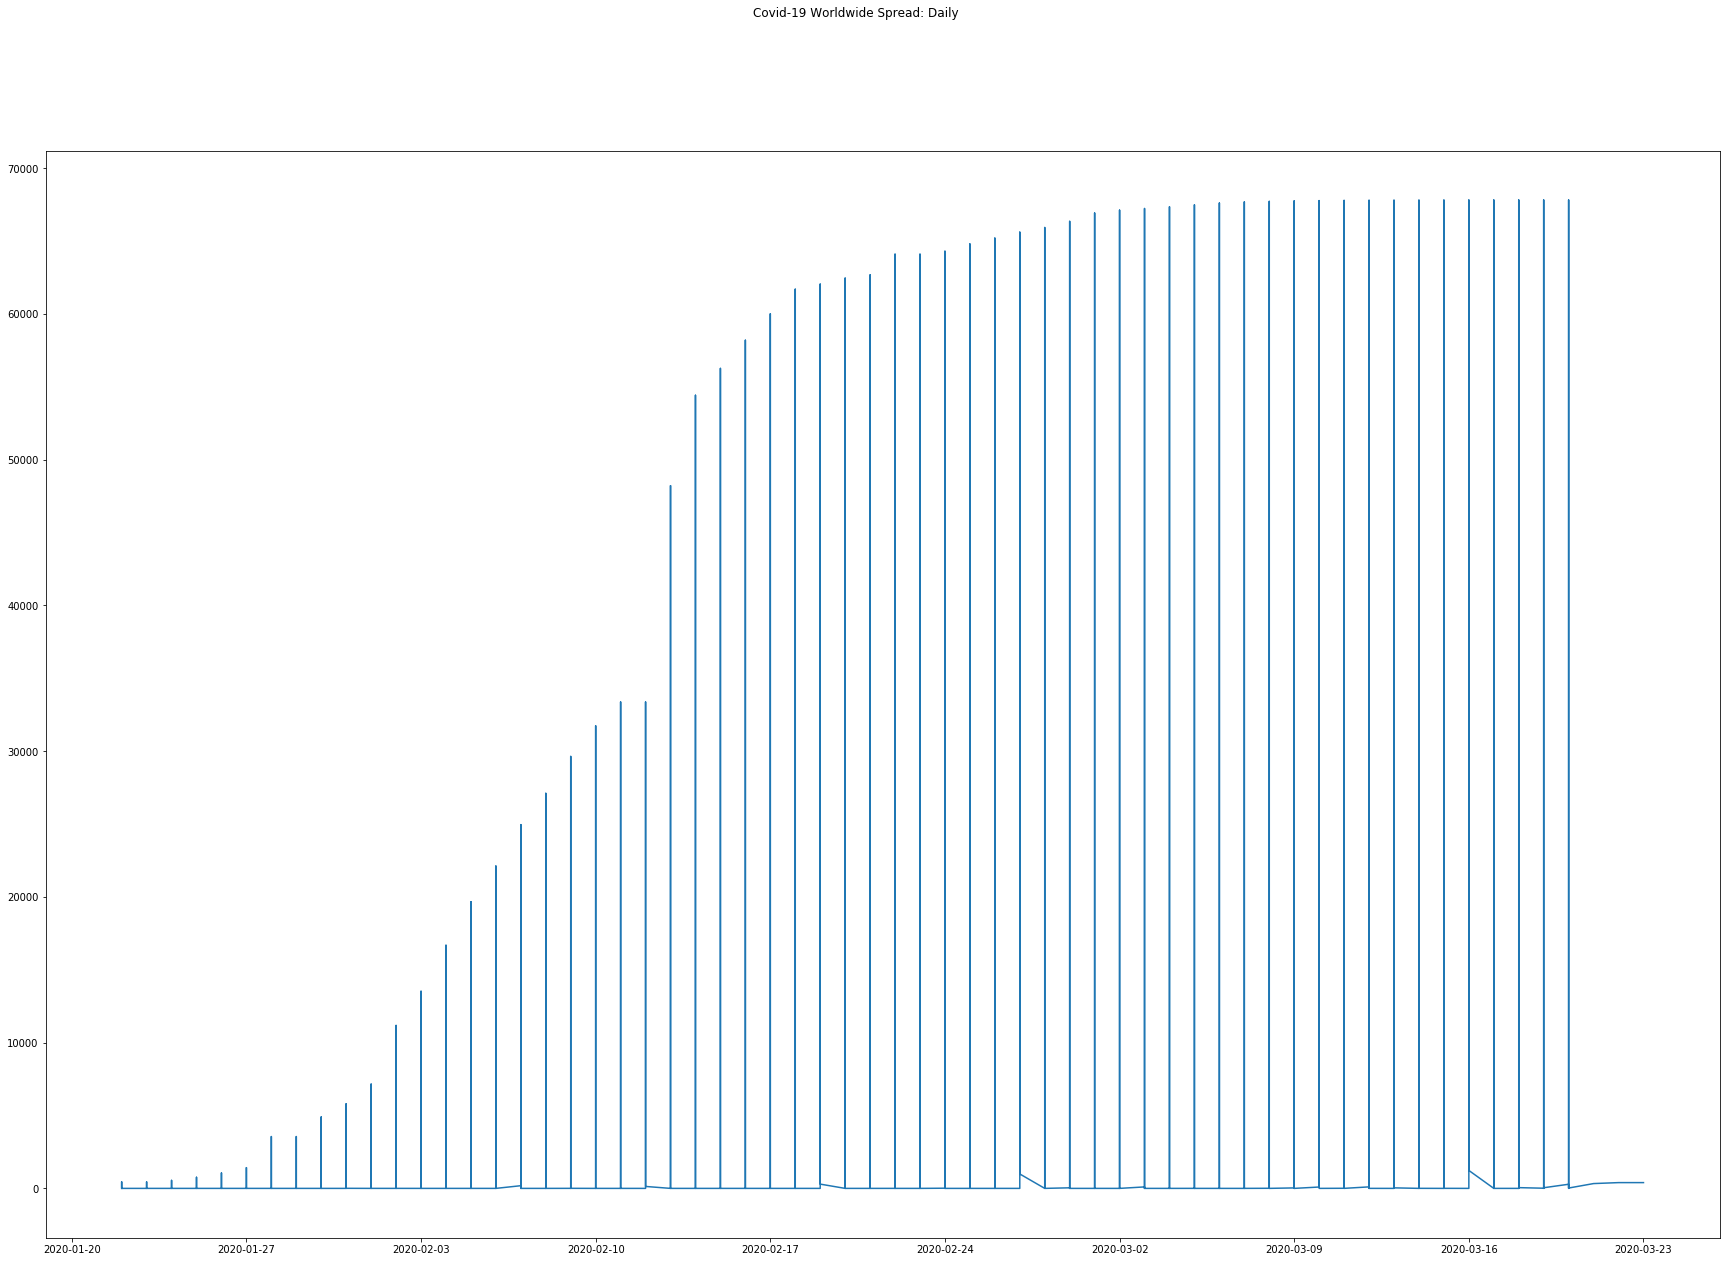

In [13]:
##Checking overallTrend of data

fig = plt.figure(figsize=(30,20))
fig.suptitle('Covid-19 Worldwide Spread: Daily')
plt.plot(data_confirmed['Date'],data_confirmed['Cases'])

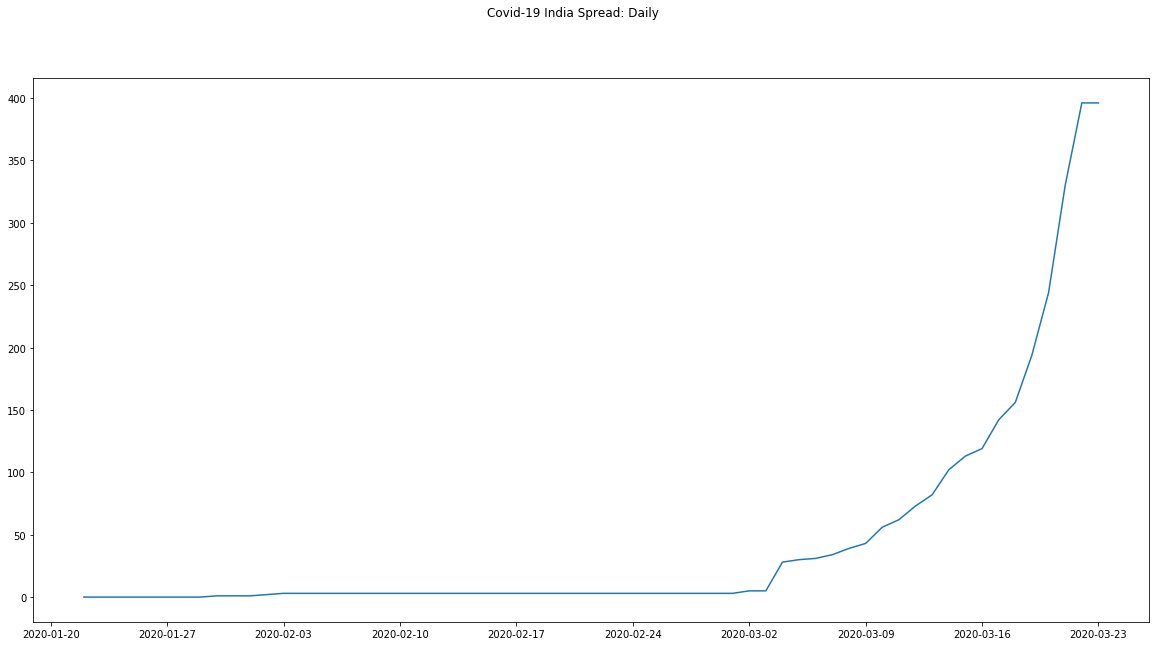

In [16]:
##Checking Trend of Reported Case in India

fig = plt.figure(figsize=(20,10))
fig.suptitle('Covid-19 India Spread: Daily')

plt.plot(data_confirmed[data_confirmed['Country/Region']=='India']['Date'],data_confirmed[data_confirmed['Country/Region']=='India']['Cases'])

In [17]:
## Subsetting Data for India

data_ind = data_confirmed[data_confirmed['Country/Region']=='India']

data_ind.shape

(62, 9)

In [18]:
## Defining Target and Training Data

train_y = data_ind.Cases
train_df = data_ind.drop(["Country/Region","Cases","Province/State","Date","Lat","Long"], axis=1)

In [19]:
## Train-Test Split

mask = np.random.rand(len(data_ind)) < 0.8
df_train = data_ind[mask]
df_test = data_ind[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=52
Testing data set length=10


In [20]:
## Defining Poisson Equation

expr = """Cases ~ Month +  
                  DayOfYear """

## Set up the X and y matrices for the training and testing data sets

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [21]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   52
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -164.49
Date:                Fri, 27 Mar 2020   Deviance:                       147.61
Time:                        20:48:22   Pearson chi2:                     231.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.6111      0.341    -19.377      0.000      -7.280      -5.942
Month          0.0072      0.154      0.047      0.9

In [47]:
#make some predictions using our trained NB2 model
poisson_predictions_train = poisson_training_results.get_prediction(X_train)

#print out the predictions
predictions_summary_frame_training = poisson_predictions_train.summary_frame()
print(predictions_summary_frame_training)

             mean    mean_se  mean_ci_lower  mean_ci_upper
28146    0.037497   0.008604       0.023915       0.058792
28145    0.043606   0.009964       0.027864       0.068241
28144    0.050710   0.011543       0.032459       0.079224
7729     0.058971   0.013378       0.037804       0.091991
7728     0.068579   0.015512       0.044021       0.106836
7726     0.092744   0.020879       0.059657       0.144181
7725     0.107853   0.024238       0.069428       0.167543
7724     0.125424   0.028151       0.080785       0.194729
7723     0.145857   0.032710       0.093980       0.226369
7722     0.170842   0.026277       0.126378       0.230949
7721     0.198674   0.029920       0.147894       0.266890
7719     0.268680   0.038806       0.202440       0.356596
7718     0.312452   0.044206       0.236785       0.412300
7717     0.363355   0.050372       0.276904       0.476796
7716     0.422551   0.057416       0.323755       0.551494
7715     0.491390   0.065474       0.378452       0.6380

In [48]:
## Prediction Error on training set
mean_absolute_error(y_train['Cases'].astype('int'), predictions_summary_frame_training['mean'].astype('int'))

4.788461538461538

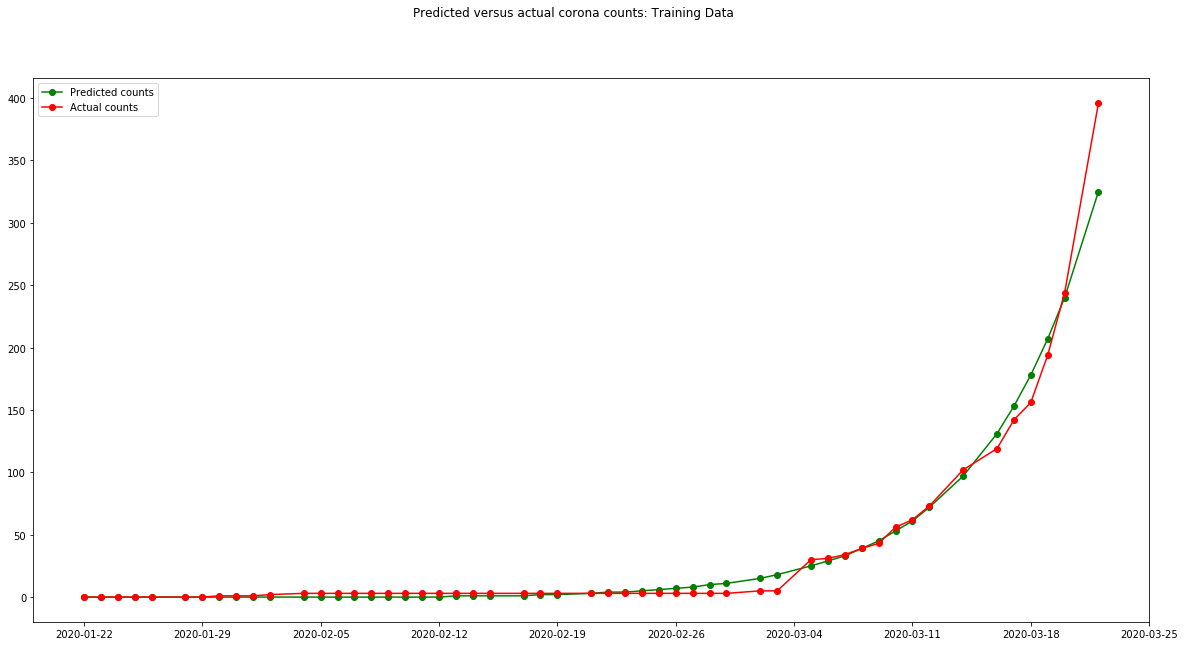

In [52]:
predicted_counts_trained=predictions_summary_frame_training['mean'].astype('int')
actual_counts_trained = y_train['Cases'].astype('int')
plot_train = pd.concat([df_train['Date'],actual_counts_trained,predicted_counts_trained],axis=1)

fig = plt.figure(figsize=(20,10))
fig.suptitle('Predicted versus actual corona counts: Training Data')
predicted, = plt.plot(plot_train.Date, plot_train['mean'], 'go-', label='Predicted counts')
actual, = plt.plot(plot_train.Date, plot_train.Cases, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [25]:
#make some predictions using our trained Poisson model
poisson_predictions = poisson_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)


            mean    mean_se  mean_ci_lower  mean_ci_upper
7727    0.079751   0.017992       0.051251       0.124100
7720    0.231041   0.034072       0.173045       0.308474
7707    1.643640   0.192186       1.307007       2.066976
7703    3.006055   0.338734       2.410351       3.748984
7693   13.695933   1.057099      11.773158      15.932732
7690   21.539432   1.376340      19.003940      24.413209
7681   83.784214   2.456455      79.105370      88.739798
7679  113.307146   2.848542     107.859422     119.030020
7673  280.248047   8.931307     263.278506     298.311355
7671  378.998676  14.673567     351.303117     408.877660


In [46]:
## Prediction Error on test set
mean_absolute_error(y_test['Cases'].astype('int'), predictions_summary_frame['mean'].astype('int'))

9.1

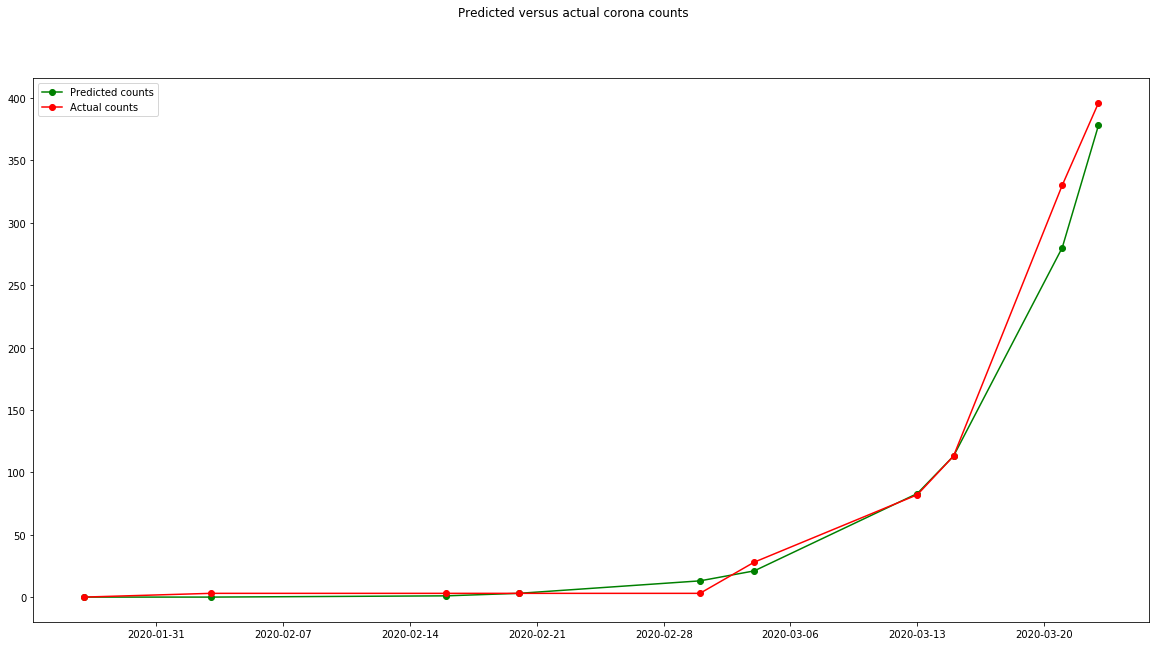

In [42]:
predicted_counts=predictions_summary_frame['mean'].astype('int')
actual_counts = y_test['Cases'].astype('int')
plot = pd.concat([df_test['Date'],actual_counts,predicted_counts],axis=1)

fig = plt.figure(figsize=(20,10))
fig.suptitle('Predicted versus actual corona counts: Test Data')
predicted, = plt.plot(plot.Date, plot['mean'], 'go-', label='Predicted counts')
actual, = plt.plot(plot.Date, plot.Cases, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

##### Now we will be predicting the Covid-19 cases to be reported in India from 26th Mar to 15th April

In [29]:
## Importing the data
val_data = pd.read_csv('data/val_data.csv')

In [30]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
Intercept     23 non-null int64
Country       23 non-null object
Date          23 non-null object
DayOfMonth    23 non-null int64
Quarter       23 non-null int64
Month         23 non-null int64
WeekNumber    0 non-null float64
DayOfYear     0 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1.5+ KB


In [31]:
val_data['Date'] = [ datetime.datetime.strptime(x,'%d-%m-%Y') for x in val_data['Date']]
val_data['WeekNumber'] = [x.week for x in val_data['Date']]
val_data["DayOfYear"] = val_data["Date"].apply(lambda x: x.timetuple().tm_yday)

In [32]:
val_data.head()

,Intercept,Country,Date,DayOfMonth,Quarter,Month,WeekNumber,DayOfYear
0,1,India,2020-03-24,24,1,3,13,84
1,1,India,2020-03-25,25,1,3,13,85
2,1,India,2020-03-26,26,1,3,13,86
3,1,India,2020-03-27,27,1,3,13,87
4,1,India,2020-03-28,28,1,3,13,88


In [33]:
val_data_pred = val_data.drop(['Date','Country','DayOfMonth','Quarter','WeekNumber'],axis=1)

In [34]:
val_data_pred.head()

,Intercept,Month,DayOfYear
0,1,3,84
1,1,3,85
2,1,3,86
3,1,3,87
4,1,3,88


In [35]:
poisson_predictions_ind = poisson_training_results.get_prediction(val_data_pred)

#print out the predictions
predictions_summary_frame_ind = poisson_predictions_ind.summary_frame()
print(predictions_summary_frame_ind)

            mean      mean_se  mean_ci_lower  mean_ci_upper
0     440.742817    18.736973     405.507361     479.039961
1     512.545933    23.821176     467.920634     561.427119
2     596.046773    30.141406     539.803939     658.149617
3     693.151058    37.957951     622.608244     771.686521
4     806.074978    47.584736     718.003835     904.949024
5     937.395770    59.399550     827.914085    1061.355091
6    1090.110540    73.856271     954.554289    1244.917133
7    1267.704663    91.499419    1100.476348    1460.344982
8    1484.857642   185.916772    1161.735245    1897.852567
9    1726.761543   214.315889    1353.898292    2202.311239
10   2008.074943   247.376674    1577.319181    2556.467346
11   2335.218198   285.929164    1836.980345    2968.591389
12   2715.657626   330.960410    2138.641923    3448.354893
13   3158.075912   383.644739    2488.961332    4007.070474
14   3672.570271   445.379743    2895.631197    4657.973160
15   4270.882897   517.829038    3367.53

In [36]:
india_prediction = pd.concat([val_data['Date'],predictions_summary_frame_ind['mean'].astype('int')],axis=1)

print(india_prediction)

india_prediction.to_csv('india_prediction.csv',index=False)

         Date   mean
0  2020-03-24    440
1  2020-03-25    512
2  2020-03-26    596
3  2020-03-27    693
4  2020-03-28    806
5  2020-03-29    937
6  2020-03-30   1090
7  2020-03-31   1267
8  2020-04-01   1484
9  2020-04-02   1726
10 2020-04-03   2008
11 2020-04-04   2335
12 2020-04-05   2715
13 2020-04-06   3158
14 2020-04-07   3672
15 2020-04-08   4270
16 2020-04-09   4966
17 2020-04-10   5775
18 2020-04-11   6716
19 2020-04-12   7811
20 2020-04-13   9083
21 2020-04-14  10563
22 2020-04-15  12284


In [56]:
india_prediction = india_prediction.rename(columns={'mean':'Cases'})

In [58]:
# india_prediction

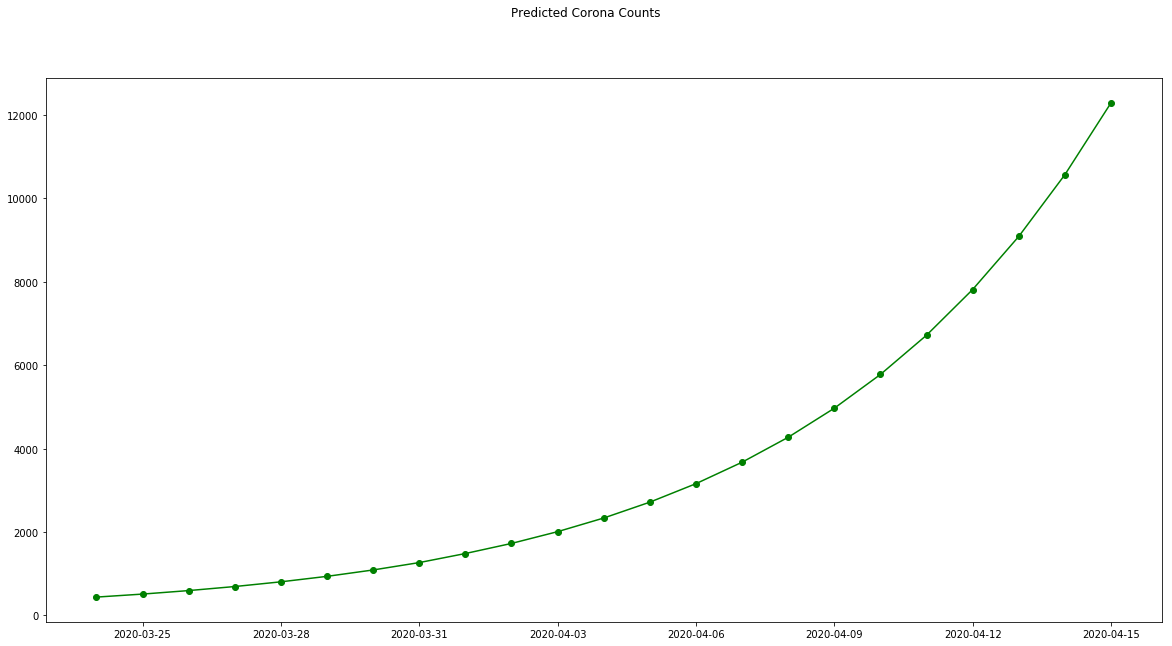

In [37]:
predicted_counts=india_prediction['mean']
fig = plt.figure(figsize=(20,10))
fig.suptitle('Predicted Corona Counts')
predicted, = plt.plot(india_prediction.Date, predicted_counts, 'go-', label='Predicted counts')
plt.show()

In [7]:
india = pd.read_csv('01_State_wise_cv19india.csv')

In [8]:
india.head()

,Unnamed: 0,active,confirmed,deaths,deltaconfirmed,deltadeaths,deltarecovered,lastupdatedtime,recovered,state,statecode,statenotes
0,28,0,33,0,0,0,0,07/05/2020 22:24:57,33,Andaman and Nicobar Islands,AN,NaN
1,9,843,2560,53,0,0,0,20/05/2020 16:57:25,1664,Andhra Pradesh,AP,Total includes patients from other states.
2,33,0,1,0,0,0,0,16/04/2020 19:33:11,1,Arunachal Pradesh,AR,NaN
3,21,134,190,4,1,0,0,21/05/2020 12:10:27,49,Assam,AS,Includes one case from Nagaland <br>\nTotal of...
4,12,1123,1703,9,96,0,0,21/05/2020 15:13:24,571,Bihar,BR,NaN
